In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ic2dataset/IC2idmapping_2023_10_09.fasta
/kaggle/input/dernierfasta/dernieridmapping_2023_10_07.fasta
/kaggle/input/gpcr2-dataset/GPCR2_idmapping_2023_10_09.fasta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.0/777.0 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 13.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 3.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


count     204.000000
mean      851.348039
std       789.263922
min       103.000000
25%       452.000000
50%       529.000000
75%       931.250000
max      5038.000000
dtype: float64


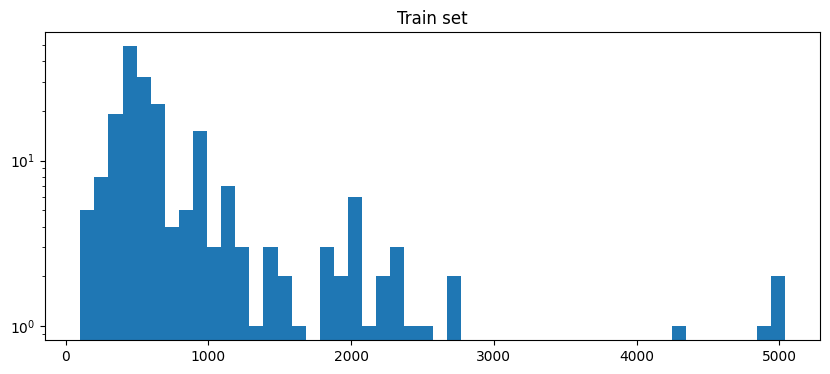

204it [03:52,  1.14s/it]

Time: 232.14676070213318


In [2]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install transformers
!pip install obonet
!pip install pyvis
!pip install biopython
!pip install sentencepiece
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# data check
from collections import Counter

# transformer
import torch
from transformers import BertModel, BertTokenizer
#import datasets

# analysis
#from sklearn.cluster import KMeans
#from sklearn.mixture import GaussianMixture
#from sklearn.cluster import AgglomerativeClustering
#from umap import UMAP
#from sklearn.preprocessing import MinMaxScaler

# visualization
#import seaborn as sns
import matplotlib.pyplot as plt

import time

# use biopython to extract protein properties
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# util
from tqdm import tqdm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

device = torch.device('cpu')
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert").to(device)

from Bio import SeqIO
train_fn = '/kaggle/input/ic2dataset/IC2idmapping_2023_10_09.fasta'


sequences = SeqIO.parse(train_fn, "fasta")

train_l = [len(seq) for seq in sequences ]
print(pd.Series(train_l).describe() )
plt.figure(figsize=(10,4))
plt.title('Train set')
plt.hist(train_l, bins=50)
plt.yscale('log')

plt.yscale('log')
plt.show()
clip_first_n_symbols=1200

sequences = SeqIO.parse(train_fn, "fasta")
emb_list = []
id_list = []
t00 = time.time()
for seq in tqdm(sequences):
    t0 = time.time()
    sequence_example = seq[:clip_first_n_symbols]
    sequence_example = ' '.join(list(sequence_example))

    encoded_input = tokenizer(sequence_example, return_tensors='pt').to(device)
    output = model(**encoded_input)
    id_list.append(seq.id)
    emb_list.append(output['last_hidden_state'][:, 0][0].detach().cpu().numpy())

print('Time:', time.time() - t00)

np.save('protein_gpcr_ids.npy', np.array(id_list))
np.save('protbert_gpcr_embeddings.npy', np.array(emb_list))
